# YOLO Pose Estimation Model Comparison

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
import pandas as pd

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

In [43]:
MODEL_CONFIGS = {
    'yolov8': ['yolov8s-pose.pt', 'yolov8m-pose.pt', 'yolov8l-pose.pt'],
    'yolo11': ['yolo11s-pose.pt', 'yolo11m-pose.pt', 'yolo11l-pose.pt']
}

MODELS = []
for version, model_names in MODEL_CONFIGS.items():
    for model_name in model_names:
        if 's-pose' in model_name:
            size = 's'
        elif 'm-pose' in model_name:
            size = 'm'
        elif 'l-pose' in model_name:
            size = 'l'
        else:
            size = 'unknown'
        
        display_name = model_name.replace('.pt', '')
        
        MODELS.append({
            'version': version,
            'size': size,
            'name': model_name,
            'display_name': display_name
        })

print("Models to compare:")
for model in MODELS:
    print(f"  - {model['display_name']}")

Models to compare:
  - yolov8s-pose
  - yolov8m-pose
  - yolov8l-pose
  - yolo11s-pose
  - yolo11m-pose
  - yolo11l-pose


## Video Discovery

In [45]:
def extract_shot_type(video_path):
    # Format: joined_{ShotType}_{clips}_{timestamp}.mp4
    parts = video_path.stem.split('_')
    shot_parts = []
    for part in parts[1:]:  # Skip 'joined'
        if part.isdigit() or part.endswith('clips'):
            break
        shot_parts.append(part)
    return '_'.join(shot_parts)

def print_video_info(video_path):
    cap = cv2.VideoCapture(str(video_path))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps if fps > 0 else 0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    
    shot_type = extract_shot_type(video_path)
    print(f"  {shot_type:20s} | {frame_count:4d} frames | {duration:5.1f}s | {width}x{height}")

dataset_path = Path("./dataset")
VIDEOS = sorted(list(dataset_path.glob("*.mp4")))

print(f"Found {len(VIDEOS)} videos:\n")
for video_path in VIDEOS:
    print_video_info(video_path)

Found 8 videos:

  Backhand             |  224 frames |   7.5s | 1920x1080
  Backhand_Volley      |  374 frames |  12.5s | 1920x1080
  Contrapared          |   42 frames |   1.4s | 1920x1080
  Forehand             |  349 frames |  11.6s | 1920x1080
  Forehand_Volley      |  184 frames |   6.1s | 1920x1080
  Lob                  |  223 frames |   7.4s | 1920x1080
  Smash                |  147 frames |   4.9s | 1920x1080
  Vibora               |  234 frames |   7.8s | 1920x1080


## Load Models

In [53]:
def load_models():
    print("Loading models...\n")
    for model_config in MODELS:
        print(f"  Loading {model_config['display_name']}...", end=" ")

        model_path = f"weights/{model_config['name']}"
        model = YOLO(model_path)
        model_config['model'] = model
        
        print("✓")

load_models()

Loading models...

  Loading yolov8s-pose... ✓
  Loading yolov8m-pose... ✓
  Loading yolov8l-pose... ✓
  Loading yolo11s-pose... ✓
  Loading yolo11m-pose... ✓
  Loading yolo11l-pose... ✓


## Benchmarking Function

In [61]:
def benchmark_model_on_video(model, model_name, video_path, max_frames=100, conf_threshold=0.3):
    cap = cv2.VideoCapture(str(video_path))
    
    metrics = {
        'model_name': model_name,
        'video': video_path.name,
        'frames_processed': 0,
        'frame_times': [],
        'people_detected': [],
        'total_people': 0
    }
    
    frame_count = 0
    
    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Run the inference and time it
        start_time = time.time()
        results = model(frame, conf=conf_threshold, verbose=False)
        inference_time = time.time() - start_time
        
        metrics['frame_times'].append(inference_time)
        
        # Count detected people
        num_people = 0
        if results[0].keypoints is not None and len(results[0].keypoints.data) > 0:
            num_people = len(results[0].keypoints.data)
        
        metrics['people_detected'].append(num_people)
        metrics['total_people'] += num_people
        metrics['frames_processed'] += 1
        frame_count += 1
    
    cap.release()
    
    # Summary statistics
    if metrics['frame_times']:
        metrics['avg_inference_time'] = np.mean(metrics['frame_times'])
        metrics['fps'] = 1.0 / metrics['avg_inference_time']
    
    if metrics['people_detected']:
        metrics['avg_people_per_frame'] = np.mean(metrics['people_detected'])
    
    return metrics


## Run Benchmarks

Execute inference on all models and collect performance data. This may take a few minutes.

In [62]:
FRAMES_TO_PROCESS = 100
all_results = []

print("Starting benchmark...")
print(f"   Models: {len(MODELS)}")
print(f"   Videos: {len(VIDEOS)}")
print(f"   Frames per video: {FRAMES_TO_PROCESS}")
print(f"   Total runs: {len(MODELS) * len(VIDEOS)}\n")

for model_config in MODELS:
    model = model_config['model']
    model_name = model_config['display_name']
    
    print(f"\n{'='*60}")
    print(f"Testing: {model_name}")
    print(f"{'='*60}")
    
    for video_path in VIDEOS:
        print(f"  Processing {video_path.name}...", end=" ")

        metrics = benchmark_model_on_video(
            model=model,
            model_name=model_name,
            video_path=video_path,
            max_frames=FRAMES_TO_PROCESS,
            conf_threshold=0.3
        )
        all_results.append(metrics)
        print(f"✓ {metrics['fps']:.1f} FPS, {metrics['avg_people_per_frame']:.1f} people/frame")


print(f"\n\nBenchmark complete! Collected {len(all_results)} results.")

Starting benchmark...
   Models: 6
   Videos: 8
   Frames per video: 100
   Total runs: 48


Testing: yolov8s-pose
  Processing joined_Backhand_15clips_20251103_210348.mp4... ✓ 25.6 FPS, 2.0 people/frame
  Processing joined_Backhand_Volley_29clips_20251103_210348.mp4... ✓ 25.6 FPS, 2.0 people/frame
  Processing joined_Backhand_Volley_29clips_20251103_210348.mp4... ✓ 26.2 FPS, 2.1 people/frame
  Processing joined_Contrapared_3clips_20251103_210348.mp4... ✓ 26.2 FPS, 2.1 people/frame
  Processing joined_Contrapared_3clips_20251103_210348.mp4... ✓ 29.5 FPS, 2.5 people/frame
  Processing joined_Forehand_25clips_20251103_210348.mp4... ✓ 29.5 FPS, 2.5 people/frame
  Processing joined_Forehand_25clips_20251103_210348.mp4... ✓ 25.5 FPS, 2.1 people/frame
  Processing joined_Forehand_Volley_14clips_20251103_210349.mp4... ✓ 25.5 FPS, 2.1 people/frame
  Processing joined_Forehand_Volley_14clips_20251103_210349.mp4... ✓ 26.1 FPS, 2.3 people/frame
  Processing joined_Lob_15clips_20251103_210349.mp4.

## Results

In [63]:
# Convert results to DataFrame
df_results = pd.DataFrame([{
    'model': r['model_name'],
    'video': r['video'],
    'fps': r['fps'],
    'avg_inference_ms': r['avg_inference_time'] * 1000,
    'avg_people': r['avg_people_per_frame'],
    'total_people': r['total_people']
} for r in all_results])

# Add model metadata (version and size)
df_results['version'] = df_results['model'].apply(lambda x: 'yolov8' if x.startswith('yolov8') else 'yolo11')
df_results['size'] = df_results['model'].apply(lambda x: x[6])  # 6th char is the size (yolov8s, yolo11s)

df_results[['model', 'video', 'fps', 'avg_inference_ms', 'avg_people']].head(10)

,model,video,fps,avg_inference_ms,avg_people
0,yolov8s-pose,joined_Backhand_15clips_20251103_210348.mp4,25.553911,39.132953,1.970000
1,yolov8s-pose,joined_Backhand_Volley_29clips_20251103_210348...,26.166636,38.216605,2.120000
2,yolov8s-pose,joined_Contrapared_3clips_20251103_210348.mp4,29.528762,33.865287,2.452381
3,yolov8s-pose,joined_Forehand_25clips_20251103_210348.mp4,25.497543,39.219465,2.120000
4,yolov8s-pose,joined_Forehand_Volley_14clips_20251103_210349...,26.092319,38.325455,2.280000
5,yolov8s-pose,joined_Lob_15clips_20251103_210349.mp4,26.529185,37.694335,2.290000
6,yolov8s-pose,joined_Smash_7clips_20251103_210349.mp4,27.174349,36.799409,2.480000
7,yolov8s-pose,joined_Vibora_13clips_20251103_210349.mp4,27.496900,36.367736,2.240000
8,yolov8m-pose,joined_Backhand_15clips_20251103_210348.mp4,14.582738,68.574226,2.000000
9,yolov8m-pose,joined_Backhand_Volley_29clips_20251103_210348...,14.101692,70.913477,2.020000


## Visualizations

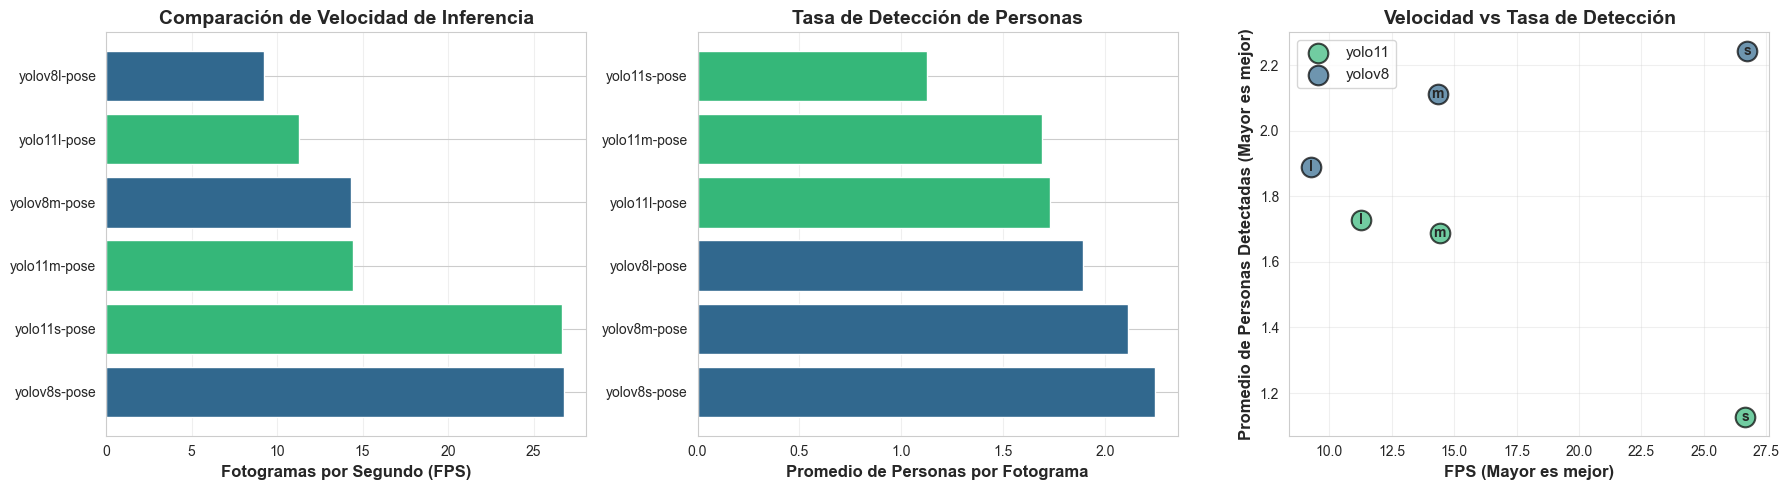

In [80]:
# Aggregate by model (average across all videos)
df_by_model = df_results.groupby(['model', 'version', 'size']).agg({
    'fps': 'mean',
    'avg_people': 'mean'
}).reset_index()

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Use seaborn color palette for high contrast
palette = sns.color_palette("viridis", n_colors=2)
colors = {'yolov8': palette[0], 'yolo11': palette[1]}

# Plot 1: FPS comparison
ax1 = axes[0]
models_sorted = df_by_model.sort_values('fps', ascending=False)
bar_colors = [colors[v] for v in models_sorted['version']]

bars = ax1.barh(models_sorted['model'], models_sorted['fps'], color=bar_colors)
ax1.set_xlabel('Fotogramas por Segundo (FPS)', fontsize=12, fontweight='bold')
ax1.set_title('Comparación de Velocidad de Inferencia', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)


# Plot 2: People detection rate
ax2 = axes[1]
models_sorted2 = df_by_model.sort_values('avg_people', ascending=False)
bar_colors2 = [colors[v] for v in models_sorted2['version']]

bars2 = ax2.barh(models_sorted2['model'], models_sorted2['avg_people'], color=bar_colors2)
ax2.set_xlabel('Promedio de Personas por Fotograma', fontsize=12, fontweight='bold')
ax2.set_title('Tasa de Detección de Personas', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: FPS vs People Detection Rate (trade-off)
ax3 = axes[2]
for version in df_by_model['version'].unique():
    version_data = df_by_model[df_by_model['version'] == version]
    ax3.scatter(version_data['fps'], version_data['avg_people'], 
               s=200, alpha=0.7, color=colors[version], label=version, edgecolors='black', linewidth=1.5)
    
    # Add labels for each point
    for idx, row in version_data.iterrows():
        ax3.annotate(row['size'], (row['fps'], row['avg_people']), 
                    fontsize=10, fontweight='bold', ha='center', va='center')

ax3.set_xlabel('FPS (Mayor es mejor)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Promedio de Personas Detectadas (Mayor es mejor)', fontsize=12, fontweight='bold')
ax3.set_title('Velocidad vs Tasa de Detección', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Pose Detection Samples

In [84]:
top_2_models = ["yolov8s-pose", "yolo11s-pose"]
top_2_configs = [m for m in MODELS if m['display_name'] in top_2_models]

In [89]:
def compare_models_on_shots(shot_types, models_to_compare, frame_idx=50, conf=0.3):
    num_shots = len(shot_types)
    num_models = len(models_to_compare)
    
    # Create grid: rows = shot types, cols = models
    fig, axes = plt.subplots(num_shots, num_models, figsize=(8*num_models, 5*num_shots))
    
    # Ensure axes is 2D
    if num_shots == 1:
        axes = axes.reshape(1, -1)
    if num_models == 1:
        axes = axes.reshape(-1, 1)
    
    for shot_idx, shot_type in enumerate(shot_types):
        # Find video for this shot type
        video_path = None
        for video in VIDEOS:
            if extract_shot_type(video) == shot_type:
                video_path = video
                break
        
        if video_path is None:
            print(f"No se encontró video para {shot_type}")
            continue
        
        # Read frame
        cap = cv2.VideoCapture(str(video_path))
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        cap.release()
        
        if not ret:
            print(f"No se pudo leer el fotograma de {shot_type}")
            continue
        
        # Process with each model
        for model_idx, model_config in enumerate(models_to_compare):
            model = model_config['model']
            model_name = model_config['display_name']
            
            # Run inference
            start_time = time.time()
            results = model(frame, conf=conf, verbose=False)
            inference_time = (time.time() - start_time) * 1000  # ms
            
            # Count people
            num_people = 0
            if results[0].keypoints is not None:
                num_people = len(results[0].keypoints.data)
            
            # Draw results
            annotated = results[0].plot()
            annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
            
            ax = axes[shot_idx, model_idx]
            ax.imshow(annotated_rgb)
            ax.set_title(
                f'{shot_type} - {model_name}\n{num_people} personas | {inference_time:.1f}ms',
                fontsize=12, fontweight='bold'
            )
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

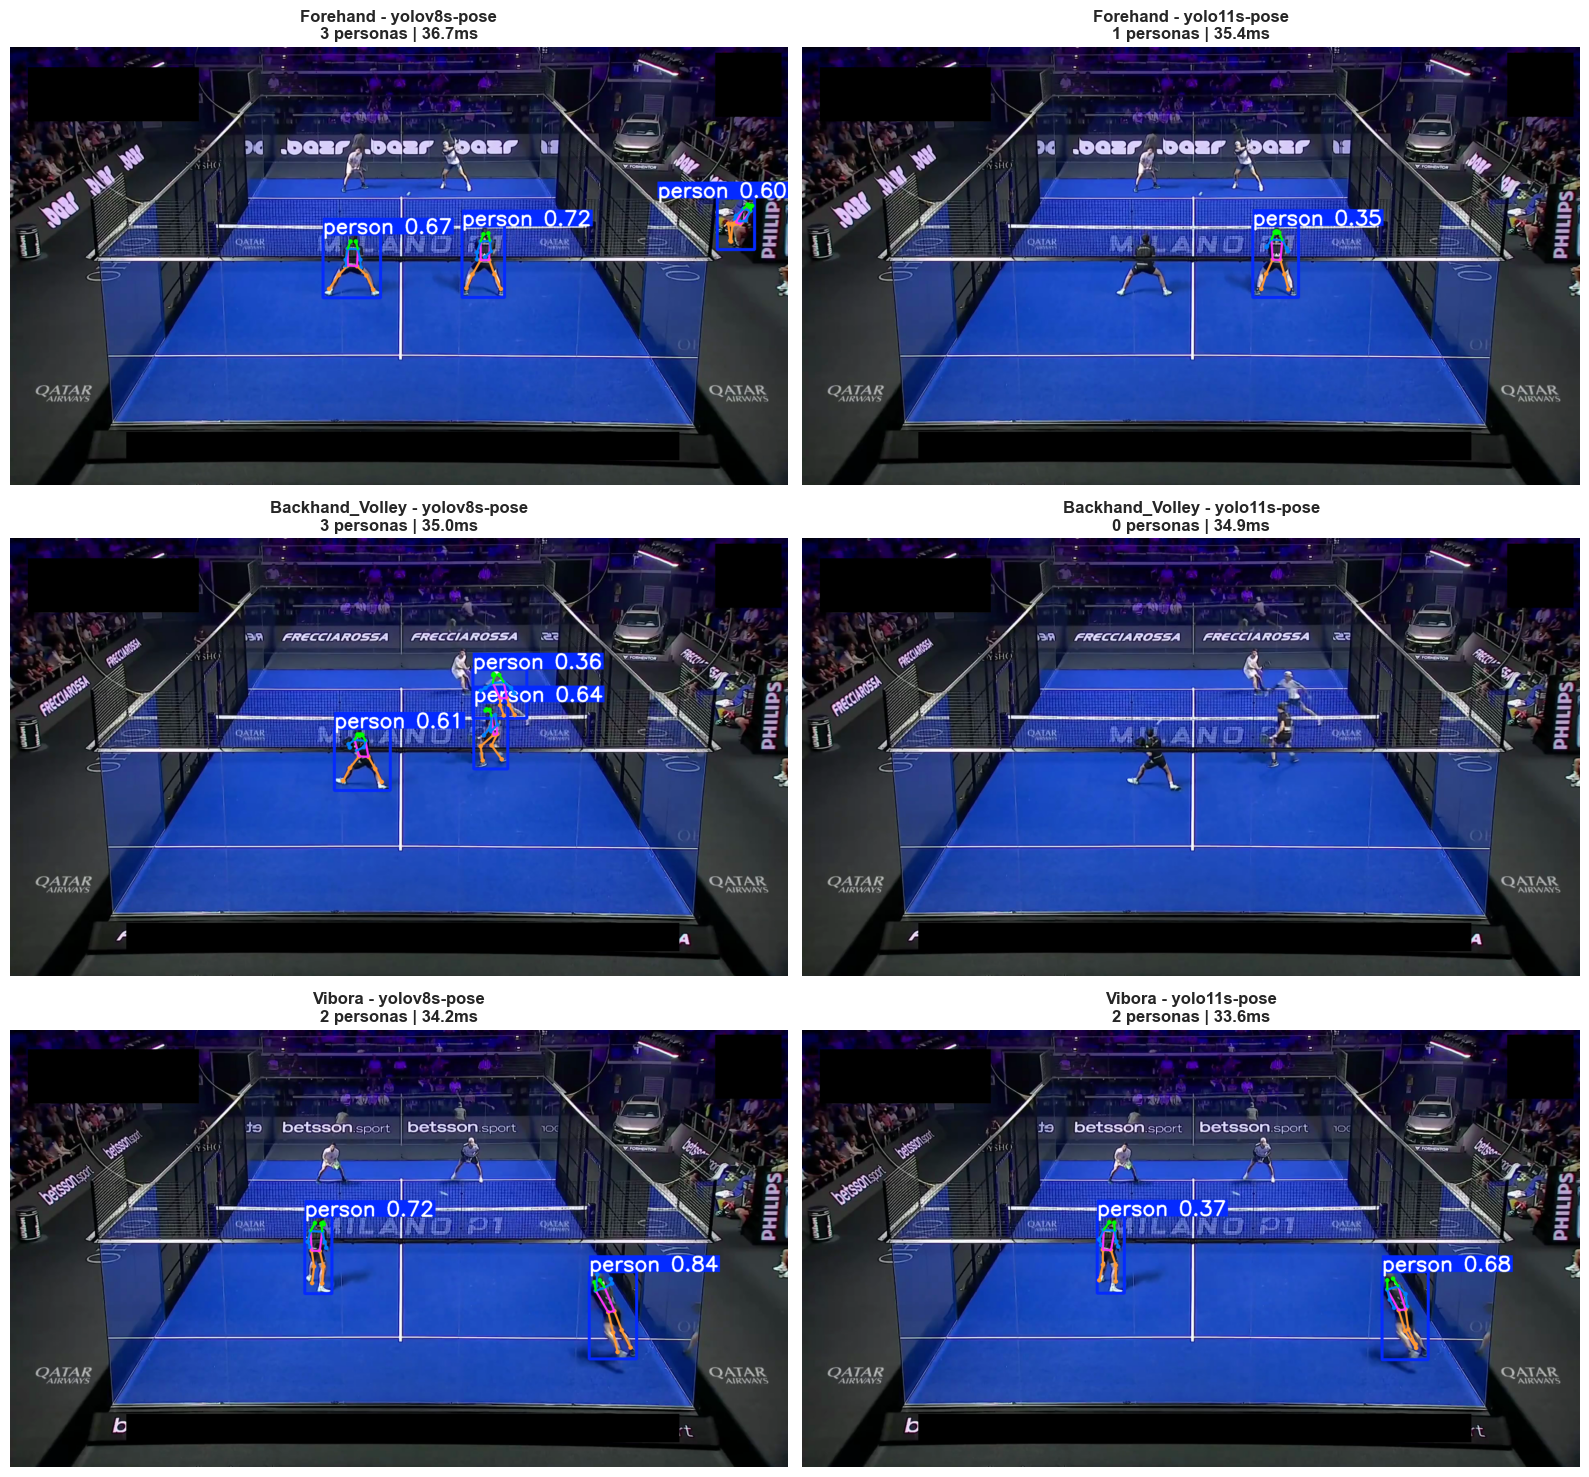

In [90]:
shot_types_to_compare = ['Forehand', 'Backhand_Volley', 'Vibora']
compare_models_on_shots(shot_types_to_compare, top_2_configs)

## Two-stage detection

1. **Stage 1**: Object detection to find persons
2. **Stage 2**: Pose estimation over each bounding box detected

In [98]:
yolo_object = YOLO('weights/yolov8s.pt')
yolo_pose = YOLO('weights/yolov8s-pose.pt')

In [99]:
def two_stage_detection(frame, object_model, pose_model, conf_object=0.3, conf_pose=0.3):
    """
    Two-stage pipeline:
    1. Detect persons with YOLO
    2. Apply pose estimation to each bounding box
    """
    # Stage 1: Object detection to find all people
    object_results = object_model(frame, conf=conf_object, verbose=False)
    
    # Filter for person class (class 0 in COCO)
    person_bboxes = []
    if object_results[0].boxes is not None:
        boxes = object_results[0].boxes
        for i, cls in enumerate(boxes.cls):
            if int(cls) == 0:  # Person class
                person_bboxes.append(boxes.xyxy[i].cpu().numpy())
    
    # Stage 2: Run pose estimation on each detected person
    all_keypoints = []
    all_boxes = []
    
    for person in person_bboxes:
        x1, y1, x2, y2 = map(int, person)
        
        # Crop person region with some padding
        padding = 20
        x1 = max(0, x1 - padding)
        y1 = max(0, y1 - padding)
        x2 = min(frame.shape[1], x2 + padding)
        y2 = min(frame.shape[0], y2 + padding)
        
        person_crop = frame[y1:y2, x1:x2]
        
        if person_crop.size == 0:
            continue
        
        # Run pose estimation on crop
        pose_results = pose_model(person_crop, conf=conf_pose, verbose=False)
        
        if pose_results[0].keypoints is not None and len(pose_results[0].keypoints.data) > 0:
            # Get keypoints and adjust coordinates to original frame
            kpts = pose_results[0].keypoints.data[0].cpu().numpy()
            kpts[:, 0] += x1  # Adjust x coordinates
            kpts[:, 1] += y1  # Adjust y coordinates
            
            all_keypoints.append(kpts)
            all_boxes.append([x1, y1, x2, y2])
    
    return all_keypoints, all_boxes, person_bboxes


def visualize_pose_detections(frame, keypoints_list):
    """
    Dibuja keypoints de pose usando el método de visualización de ultralytics
    """
    from ultralytics.utils.plotting import Annotator, colors
    
    annotator = Annotator(frame.copy(), line_width=2)
    
    for kpts in keypoints_list:
        # Use ultralytics' built-in kpts plotting which matches the one-stage visualization
        annotator.kpts(kpts, shape=(frame.shape[0], frame.shape[1]), radius=5, kpt_line=True)
    
    return annotator.result()

### One-stage vs Two-stage

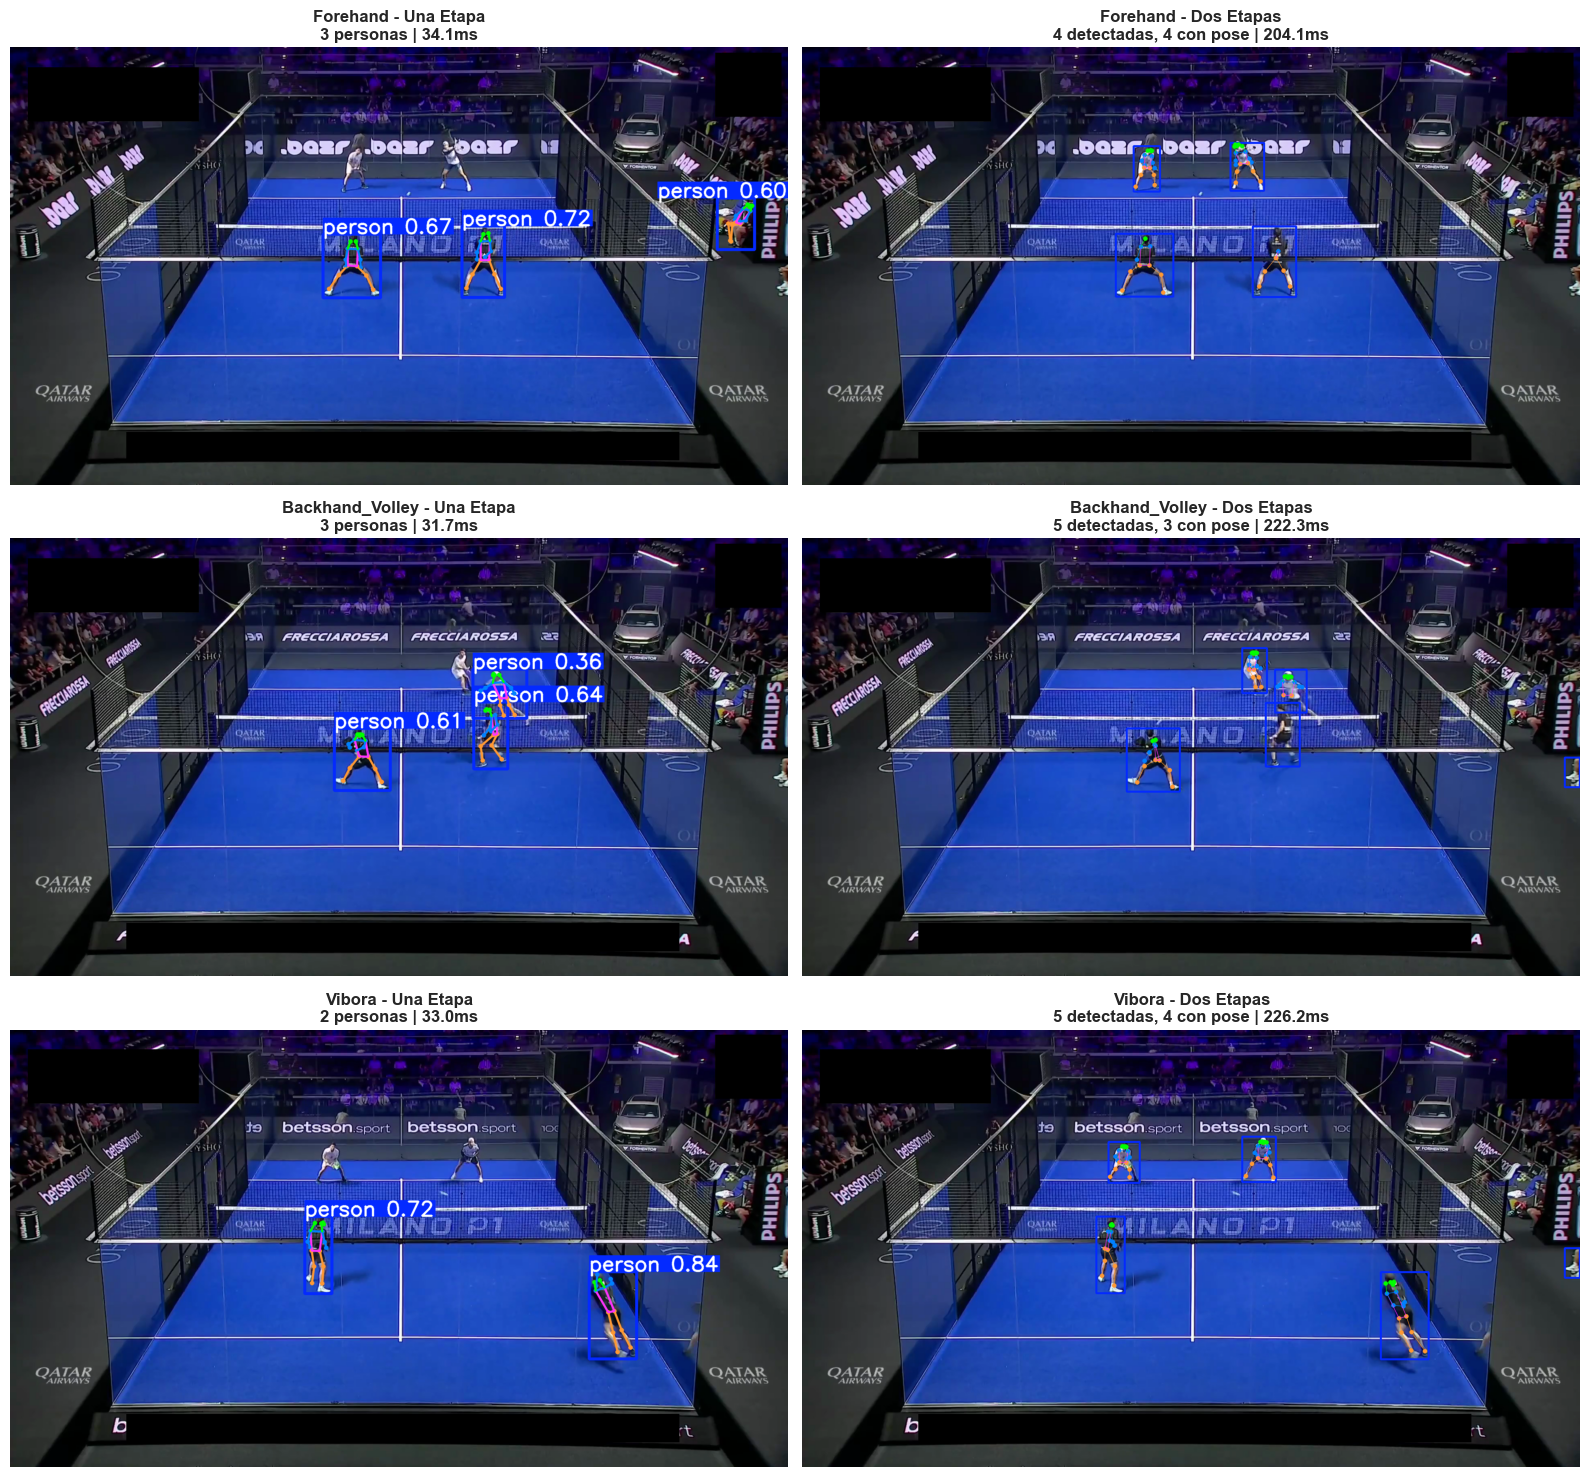

In [107]:
# Compare single-stage vs two-stage on sample frames
shot_types_for_comparison = ['Forehand', 'Backhand_Volley', 'Vibora']

fig, axes = plt.subplots(len(shot_types_for_comparison), 2, figsize=(16, 5*len(shot_types_for_comparison)))

for shot_idx, shot_type in enumerate(shot_types_for_comparison):
    # Find video for this shot type
    video_path = None
    for video in VIDEOS:
        if extract_shot_type(video) == shot_type:
            video_path = video
            break
    
    if video_path is None:
        continue
    
    # Read frame
    cap = cv2.VideoCapture(str(video_path))
    cap.set(cv2.CAP_PROP_POS_FRAMES, 50)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        continue
    
    # Method 1: Single-stage (direct YOLO-pose)
    start_time = time.time()
    pose_results = yolo_pose(frame, conf=0.3, verbose=False)
    time_single = (time.time() - start_time) * 1000
    
    annotated_single = pose_results[0].plot()
    annotated_single_rgb = cv2.cvtColor(annotated_single, cv2.COLOR_BGR2RGB)
    
    num_people_single = 0
    if pose_results[0].keypoints is not None:
        num_people_single = len(pose_results[0].keypoints.data)
    
    axes[shot_idx, 0].imshow(annotated_single_rgb)
    axes[shot_idx, 0].set_title(
        f'{shot_type} - Una Etapa\n{num_people_single} personas | {time_single:.1f}ms',
        fontsize=12, fontweight='bold'
    )
    axes[shot_idx, 0].axis('off')
    
    # Method 2: Two-stage (detect then pose)
    start_time = time.time()
    keypoints_list, pose_boxes, detect_boxes = two_stage_detection(frame, yolo_object, yolo_pose)
    time_twostage = (time.time() - start_time) * 1000
    
    # Visualize
    annotated_twostage = frame.copy()
    
    # Draw detection boxes in bright blue with thicker lines
    for person in detect_boxes:
        x1, y1, x2, y2 = map(int, person)
        cv2.rectangle(annotated_twostage, (x1, y1), (x2, y2), (255, 42, 4), 3)  # BGR: bright blue
    
    # Draw pose keypoints
    annotated_twostage = visualize_pose_detections(annotated_twostage, keypoints_list)
    annotated_twostage_rgb = cv2.cvtColor(annotated_twostage, cv2.COLOR_BGR2RGB)
    
    num_people_twostage = len(keypoints_list)
    num_detected = len(detect_boxes)
    
    axes[shot_idx, 1].imshow(annotated_twostage_rgb)
    axes[shot_idx, 1].set_title(
        f'{shot_type} - Dos Etapas\n{num_detected} detectadas, {num_people_twostage} con pose | {time_twostage:.1f}ms',
        fontsize=12, fontweight='bold'
    )
    axes[shot_idx, 1].axis('off')

plt.tight_layout()
plt.show()

In [109]:
# Benchmark both approaches on a sample of videos
comparison_results = []

print("Comparando enfoques en videos de muestra...")

for video_path in VIDEOS[:min(5, len(VIDEOS))]:
    shot_type = extract_shot_type(video_path)
    print(f"  Procesando {shot_type}...")
    
    cap = cv2.VideoCapture(str(video_path))
    
    frames_to_test = 50
    single_stage_people = []
    two_stage_people = []
    single_stage_times = []
    two_stage_times = []
    
    for i in range(frames_to_test):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Single-stage
        start = time.time()
        pose_results = yolo_pose(frame, conf=0.3, verbose=False)
        single_stage_times.append((time.time() - start) * 1000)
        
        num_single = 0
        if pose_results[0].keypoints is not None:
            num_single = len(pose_results[0].keypoints.data)
        single_stage_people.append(num_single)
        
        # Two-stage
        start = time.time()
        keypoints_list, _, _ = two_stage_detection(frame, yolo_object, yolo_pose)
        two_stage_times.append((time.time() - start) * 1000)
        two_stage_people.append(len(keypoints_list))
    
    cap.release()
    
    comparison_results.append({
        'shot_type': shot_type,
        'avg_people_single': np.mean(single_stage_people),
        'avg_people_twostage': np.mean(two_stage_people),
        'avg_time_single': np.mean(single_stage_times),
        'avg_time_twostage': np.mean(two_stage_times),
        'improvement': np.mean(two_stage_people) - np.mean(single_stage_people)
    })

df_comparison = pd.DataFrame(comparison_results)

print("\nResumen:")
print(f"  Promedio de personas detectadas (Una Etapa): {df_comparison['avg_people_single'].mean():.2f}")
print(f"  Promedio de personas detectadas (Dos Etapas): {df_comparison['avg_people_twostage'].mean():.2f}")
print(f"  Mejora promedio: +{df_comparison['improvement'].mean():.2f} personas")
print(f"  Tiempo promedio (Una Etapa): {df_comparison['avg_time_single'].mean():.1f}ms")
print(f"  Tiempo promedio (Dos Etapas): {df_comparison['avg_time_twostage'].mean():.1f}ms")
print(f"  Overhead de tiempo: +{df_comparison['avg_time_twostage'].mean() - df_comparison['avg_time_single'].mean():.1f}ms")

df_comparison

Comparando enfoques en videos de muestra...
  Procesando Backhand...
  Procesando Backhand_Volley...
  Procesando Backhand_Volley...
  Procesando Contrapared...
  Procesando Contrapared...
  Procesando Forehand...
  Procesando Forehand...
  Procesando Forehand_Volley...
  Procesando Forehand_Volley...

Resumen:
  Promedio de personas detectadas (Una Etapa): 2.14
  Promedio de personas detectadas (Dos Etapas): 4.00
  Mejora promedio: +1.86 personas
  Tiempo promedio (Una Etapa): 34.6ms
  Tiempo promedio (Dos Etapas): 216.4ms
  Overhead de tiempo: +181.7ms

Resumen:
  Promedio de personas detectadas (Una Etapa): 2.14
  Promedio de personas detectadas (Dos Etapas): 4.00
  Mejora promedio: +1.86 personas
  Tiempo promedio (Una Etapa): 34.6ms
  Tiempo promedio (Dos Etapas): 216.4ms
  Overhead de tiempo: +181.7ms


,shot_type,avg_people_single,avg_people_twostage,avg_time_single,avg_time_twostage,improvement
0,Backhand,2.000000,4.160000,39.483833,244.663692,2.160000
1,Backhand_Volley,2.040000,4.080000,33.137660,220.634446,2.040000
2,Contrapared,2.452381,4.071429,33.202080,198.556622,1.619048
3,Forehand,2.220000,3.680000,33.488555,203.551106,1.460000
4,Forehand_Volley,2.000000,4.000000,33.890433,214.399681,2.000000
